# Implementation of Conditional GANs
Reference: https://arxiv.org/pdf/1411.1784.pdf

Fuente: https://github.com/Yangyangii/GAN-Tutorial


In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [23]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, 6] = 1                                                             # aca se puede cambiar la etiqueta del numero a generar
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        return y_

In [8]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [10]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)


In [11]:
D.load_state_dict(torch.load('conditional_D.pkl'))

<All keys matched successfully>

In [12]:
G.load_state_dict(torch.load('conditional_G.pkl'))

<All keys matched successfully>

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [14]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 92921775.49it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29632019.04it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25555823.49it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20729628.69it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [15]:
batch_size = 64
condition_size = 10

In [16]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [18]:
max_epoch = 100 # need more than 100 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [19]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [19]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [20]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.4331977367401123, G Loss: 0.7124348878860474
Epoch: 0/100, Step: 500, D Loss: 1.3340256214141846, G Loss: 0.8200477361679077
Epoch: 1/100, Step: 1000, D Loss: 1.1691077947616577, G Loss: 0.9207292795181274
Epoch: 1/100, Step: 1500, D Loss: 1.1370007991790771, G Loss: 1.0797317028045654
Epoch: 2/100, Step: 2000, D Loss: 1.2336541414260864, G Loss: 1.5071890354156494
Epoch: 2/100, Step: 2500, D Loss: 1.3169517517089844, G Loss: 1.190122365951538
Epoch: 3/100, Step: 3000, D Loss: 1.2722538709640503, G Loss: 1.0135751962661743
Epoch: 3/100, Step: 3500, D Loss: 1.3442858457565308, G Loss: 1.2880709171295166
Epoch: 4/100, Step: 4000, D Loss: 1.301950216293335, G Loss: 0.832394003868103
Epoch: 4/100, Step: 4500, D Loss: 1.3009486198425293, G Loss: 1.2077393531799316
Epoch: 5/100, Step: 5000, D Loss: 1.392385482788086, G Loss: 0.584126353263855
Epoch: 5/100, Step: 5500, D Loss: 1.3173189163208008, G Loss: 0.7511941194534302
Epoch: 6/100, Step: 6000, D Loss: 1.2

## Sample

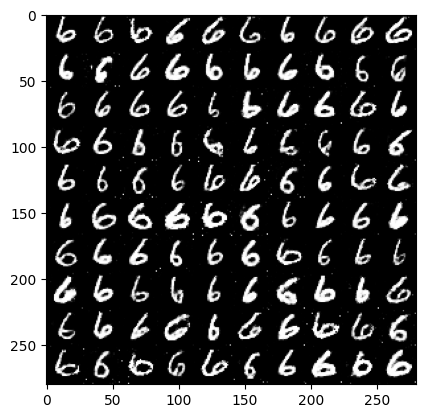

In [24]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [22]:
# Saving params.
torch.save(D.state_dict(), 'conditional_D.pkl')
torch.save(G.state_dict(), 'conditional_G.pkl')

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_c.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_c.pth.tar')